# Выбор региона для нефтедобывающей компании

## Описание проекта

Нам предоставлены пробы нефти в трёх регионах: в каждом произведено 10 000 измерений качества и объема нефти в разных месторождениях. Нам нужно определить регион, где добыча принесёт наибольшую прибыль. 

## Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Условия задачи:

- Для выполнения задания используется только линейная регрессия.
- При разведке региона проводится исследование 500 точек.
- Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
- Один баррель сырья приносит 4500 рублей прибыли.
- Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv и geo_data_2.csv.
- **id** — уникальный идентификатор месторождения;
- **f0**, **f1**, **f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в месторождении (тыс. баррелей).

## Шаг 1. Загрузка и подготовка данных

Импортируем необходимые для работы модули:

In [105]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rcParams["figure.figsize"] = (13, 6)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

R = 1512

Загрузим файлы с данными по трем регионам, изучим их содержание:

In [106]:
reg_1 = pd.read_csv('/datasets/geo_data_0.csv')
reg_2 = pd.read_csv('/datasets/geo_data_1.csv')
reg_3 = pd.read_csv('/datasets/geo_data_2.csv')
display(reg_1.head(3), reg_2.head(3), reg_3.head(3))
print(reg_1.info(), reg_2.info(), reg_3.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8

В каждом файле содержится по 100 000 записей, соответсвующих замерам параметров нефти и объема ее запасов. Пропусков нет, типы данных - вещественный, строковый (для идентификатора точки); предобработка не требуется.

Для каждого региона выделим целевой признак (объем запасов нефти) и сохраним его в переменную ***target***, а остальные признаки - в переменную ***features***. Столбцы **id** отбросим - при построении моделии регрессии идентификатор точки использоваться не будет:

In [107]:
r1_feats, r2_feats, r3_feats    = [region.drop(columns = ['id', 'product']) 
                                   for region in [reg_1, reg_2, reg_3]]
r1_target, r2_target, r3_target = [region['product']
                                   for region in [reg_1, reg_2, reg_3]]

Рассмотрим распределение и диапазоны значений признаков **f1** - **f3** для трех регионов:

In [108]:
for reg_feats in [r1_feats, r2_feats, r3_feats]:
    display(reg_feats.describe().loc[['mean', 'std', 'min', 'max'], :])

,f0,f1,f2
mean,0.500419,0.250143,2.502647
std,0.871832,0.504433,3.248248
min,-1.408605,-0.848218,-12.088328
max,2.362331,1.343769,16.003790


,f0,f1,f2
mean,1.141296,-4.796579,2.494541
std,8.965932,5.119872,1.703572
min,-31.609576,-26.358598,-0.018144
max,29.421755,18.734063,5.019721


,f0,f1,f2
mean,0.002023,-0.002081,2.495128
std,1.732045,1.730417,3.473445
min,-8.760004,-7.084020,-11.970335
max,7.238262,7.844801,16.739402


В целом можно сказать, что признаки в каждом регионе принимают соизмеримые значения, стандартизация не требуется.

## Шаг 2. Обучение и проверка модели

Для каждого региона построим модель на основе регрессора **LinearRegression** из состава ***Scikit-learn*** (выбор алгоритма регрессии определен условиями задания).

In [109]:
def region_explore(reg_feats, reg_target):
    train_feats, valid_feats, train_target, valid_target = train_test_split(reg_feats, reg_target,
                                                                            train_size = 0.75,
                                                                            random_state = R)
    model = LinearRegression()
    model.fit(train_feats, train_target)
    predictions = model.predict(valid_feats) 
    return(model, valid_target, predictions)
    
r1_model, r1_predictions, r1_valid_target = region_explore(r1_feats, r1_target)

print(f'Среднее предсказанное значение target для региона 1 равно {r1_predictions.mean():.6f}')
print(f'RMSE модели равен {mean_squared_error(r1_valid_target, r1_predictions)**0.5:.6f}')

Среднее предсказанное значение target для региона 1 равно 92.295619
RMSE модели равен 37.831375


In [110]:
r2_model, r2_predictions, r2_valid_target = region_explore(r2_feats, r2_target)

print(f'Среднее предсказанное значение target для региона 2 равно {r2_predictions.mean():.6f}')
print(f'RMSE модели равен {mean_squared_error(r2_valid_target, r2_predictions)**0.5:.6f}')

Среднее предсказанное значение target для региона 2 равно 69.138708
RMSE модели равен 0.893159


In [111]:
r3_model, r3_predictions, r3_valid_target = region_explore(r3_feats, r3_target)

print(f'Среднее предсказанное значение target для региона 1 равно {r3_predictions.mean():.6f}')
print(f'RMSE модели равен {mean_squared_error(r3_valid_target, r3_predictions)**0.5:.6f}')

Среднее предсказанное значение target для региона 1 равно 94.759135
RMSE модели равен 39.891180


## Вывод

В результате работы модели мы получили следующие результаты:
 - Для региона 1: среднее значение целевого признака (объем запасов в месторождении) - 92.296 тыс. баррелей, RMSE - 37.831 тыс. баррелей;
 - Для региона 2: среднее значение - 69.139 тыс. баррелей, RMSE - 0.893;
 - Для региона 3: среднее значение - 94.759 тыс. баррелей, RMSE - 39.891.
 
Как можно видеть, в первом и третьем регионах предсказанный средний объем запасов в месторождениях выше, чем во втором, но при этом ошибки предсказаний также очень большие. Очевидно, что модель линейной регрессии в этих случаях не подходит, но ничего не поделать - как было оговорено выше, прочие модели рассматриваться не будут.

## Шаг 3. Подготовка к расчёту прибыли

Прежде оценивать вероятности прибыли и убытков рассчитаем минимально необходимый объем сырья в месторождениях. Очевидно, что он должен быть достаточен, чтобы покрыть убытки на бурение скважины:
    
    Объем сырья (в баррелях) * Стоимость барреля > Стоимость бурения
    
откуда

    Мин.объем = Стоимость бурения / Стоимость барреля

In [112]:
# Сохраним условия задания в константах:

BUDGET = 10000000000 # Общий бюджет
WELL_COST = 50000000 # Стоимость одной скважины
BARREL_PRICE = 4500  # Стоимость барреля
N_EXPLORED = 500     # Сколько месторождений исследуется при разработке региона

MIN_PROD_PER_WELL = WELL_COST / (BARREL_PRICE * 1000)               # Считаем в тысячах баррелей

print(f'Минимальный средний запас в месторождении равен {MIN_PROD_PER_WELL:.3f} тыс. баррелей.')

Минимальный средний запас в месторождении равен 11.111 тыс. баррелей.


Теперь рассчитаем, сколько месторождений мы реально можем разработать, исходя из бюджета:

In [113]:
N_MINED = int(BUDGET / WELL_COST)
print(f'Исходя из бюджета и стоимости месторождения, можно разработать {N_MINED} месторождений.')

Исходя из бюджета и стоимости месторождения, можно разработать 200 месторождений.


Следовательно, после того, как в регионе исследуется 500 месторождений, мы можем отобрать и разработать только 200 из них. 

Исходя из вышесказанного, напишем функцию для рассчета прибыли по набору месторождений. На вход этой функции будет подаваться выборка из 500 исследованных месторождений, из которых будут отобраны 200 лучших и подсчитана прибыль. Помимо этого, функция будет возвращать долю убыточных месторождений в выборке.

In [114]:
def calculate_profit(sample):
    n_unprofitable = sample[sample < MIN_PROD_PER_WELL].count()
    top_wells = sample.sort_values(ascending = False)[:N_MINED]
    profit = (top_wells.sum() * 1000 * BARREL_PRICE - BUDGET).round()
    return profit, n_unprofitable

# Проверка
calculate_profit(r1_target.sample(n = 500, random_state = R))

(112753876773.0, 8)

## Вывод

На этом шаге мы рассчитали минимальный объем сырья в месторождении, необходимый для того, чтобы оно не было убыточным. Он равен 11.11 тысяч баррелей. 

Помимо этого, мы узнали, что выделенного бюджета хватит на бурение только 200 скважин из 500 исследованных по задаче.

Следующим шагом будет применить метод bootstrap для рассчета средней прибыли и доверительных интервалов.

## Шаг 4. Расчёт прибыли и рисков 

Применим бутстрэппинг, чтобы найти распределение прибыли в регионах. Оформим его в функцию:

In [115]:
def bootstrap_profits(region, n):
    bootstrapped_profits = []
    bootstrapped_unprofitable = []
    # Бутстрэп
    for _ in range(n):
        sample = region.sample(n = N_EXPLORED, replace = True)         #выборка с возвращением
        sample_profit, sample_unprofitable = calculate_profit(sample)
        bootstrapped_profits.append(sample_profit / 1e6)        # переводим в миллионы 
        bootstrapped_unprofitable.append(sample_unprofitable)
        
    bootstrapped_profits = pd.Series(bootstrapped_profits)
    bootstrapped_unprofitable = pd.Series(bootstrapped_unprofitable)
    
    bootstrapped_profits.hist(bins = 20)                               #распределение прибылей
    
    mean_profit = int(bootstrapped_profits.mean())                     #средняя прибыль
    mean_ratio_unprof = bootstrapped_unprofitable.mean() / N_EXPLORED  #средняя доля убыточных
    lower = int(bootstrapped_profits.quantile(0.025))                       #95% интервал
    upper = int(bootstrapped_profits.quantile(0.975))
    
    return mean_profit, mean_ratio_unprof, (str(lower) + ' - ' + str(upper))

Наконец, произведем с использованием написанной функции рассчеты необходимых нам показателей для всех трех регионов:

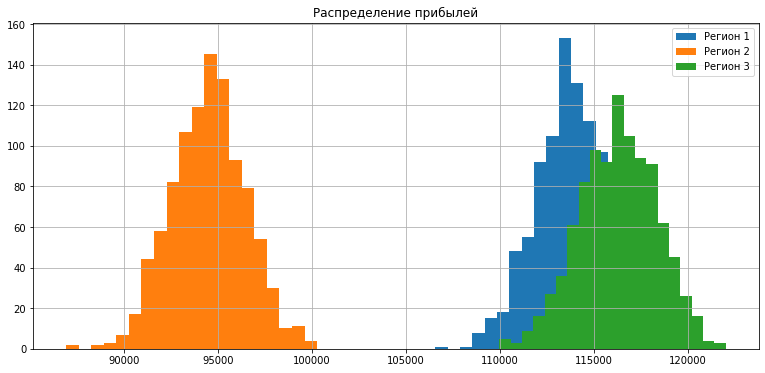

,"Средняя прибыль, млн руб.",Ср. доля убыточных месторождений,95% доверительный интервал
Регион 1,113822,0.021636,109912 - 117588
Регион 2,94487,0.165448,90702 - 98260
Регион 3,116268,0.021964,112072 - 120112


In [116]:
result = pd.DataFrame(columns = ['Средняя прибыль, млн руб.',
                                 'Ср. доля убыточных месторождений',
                                 '95% доверительный интервал'])

result.loc['Регион 1'] = bootstrap_profits(r1_target, 1000)

result.loc['Регион 2'] = bootstrap_profits(r2_target, 1000)

result.loc['Регион 3'] = bootstrap_profits(r3_target, 1000)

plt.title('Распределение прибылей')
plt.legend(['Регион 1', 'Регион 2', 'Регион 3'])
plt.show()
display(result)

Произведем для интереса аналогичные рассчеты для значений, предсказанных нашими моделями:

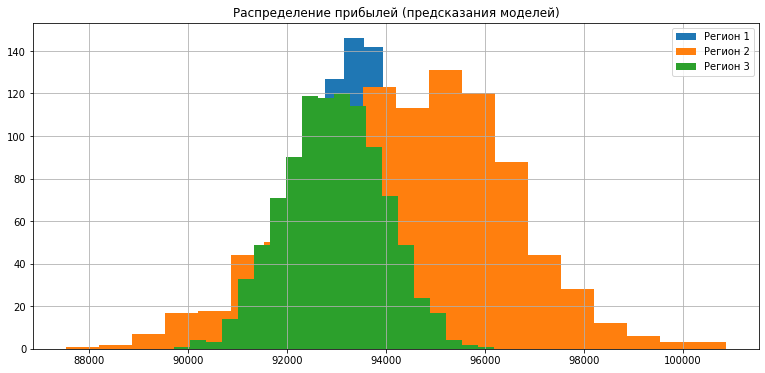

,"Средняя прибыль, млн руб.",Ср. доля убыточных месторождений,95% доверительный интервал
Регион 1,113822,0.021636,109912 - 117588
Регион 2,94487,0.165448,90702 - 98260
Регион 3,116268,0.021964,112072 - 120112
Регион 1 (модель),93590,0.000076,91360 - 96000
Регион 2 (модель),94404,0.165930,90132 - 98076
Регион 3 (модель),92938,0.000000,91038 - 94871


In [117]:
r1_predictions = pd.Series(r1_model.predict(r1_feats))
result.loc['Регион 1 (модель)'] = bootstrap_profits(r1_predictions, 1000)
r2_predictions = pd.Series(r2_model.predict(r2_feats))
result.loc['Регион 2 (модель)'] = bootstrap_profits(r2_predictions, 1000)
r3_predictions = pd.Series(r3_model.predict(r3_feats))
result.loc['Регион 3 (модель)'] = bootstrap_profits(r3_predictions, 1000)

plt.title('Распределение прибылей (предсказания моделей)')
plt.legend(['Регион 1', 'Регион 2', 'Регион 3'])
plt.show()
display(result)

Как видим, из-за плохой работы линейной регрессии для 1 и 3 региона рассчитанные значения прибыли сильно (на десятки миллиардов рублей) отличаются от реальных. Для 2 региона модель отработала хорошо.

## Вывод

На данном шаге мы с помощью метода бутстрэппинга рассчитали среднюю ожидаемую прибыль при разработке месторождений в трех регионах. Нами получены следующие результаты:

In [118]:
result.iloc[:3]

,"Средняя прибыль, млн руб.",Ср. доля убыточных месторождений,95% доверительный интервал
Регион 1,113822,0.021636,109912 - 117588
Регион 2,94487,0.165448,90702 - 98260
Регион 3,116268,0.021964,112072 - 120112


В регионе 2, несмотря на достаточно высокую среднюю ожидаемую прибыль, доля убыточных месторождений превышает 16  процентов, что нам не подходит. Поэтому данных регион мы исключаем из рассмотрения.

Из двух оставшихся регионов большая потенциальная прибыль - у региона 3: с 95-процентной вероятностью она окажется в границах между 112.3 и 120 миллиардами рублей. Прибыльность первого региона чуть меньше - 95-процентный доверительный интервал для него составляет от 109.9 до 117.7 миллиардов рублей. Доля убыточных месторождений для обоих регионов не превышает 2.2 процентов

По итогам проведенного анализа предлагается исследовать регион 3.